In [1]:
import pathlib
import dill
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = pathlib.Path('results')
files = list(path.glob("*.dill"))

In [46]:
def parse_file(f):
    split_name = f.name.split("_")
    noise = float(split_name[1])
    dt = float(split_name[-1][:-5])
    with open(f,'rb') as path:
        result = pickle.load(path)
    d = result['theta_metrics']
    d.update(result['xdot_metrics'])
    d['noise'] = np.around(np.array(noise),3)
    d['dt'] = np.around(np.array(dt),3)
    # d['var_est'] = result['model_params']['sigma2_est']
    return d

In [47]:
results = [parse_file(f) for f in files]

In [48]:
df = pd.DataFrame(results).astype('float')

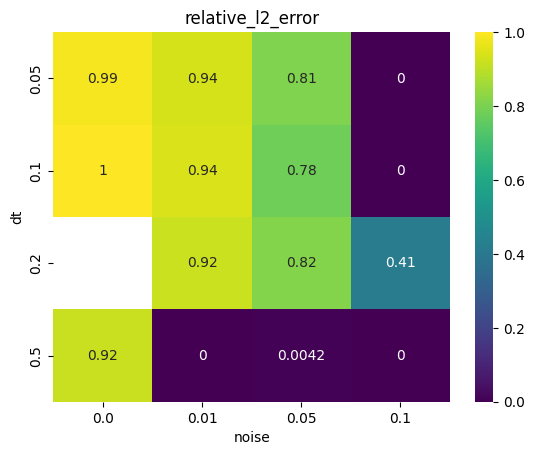

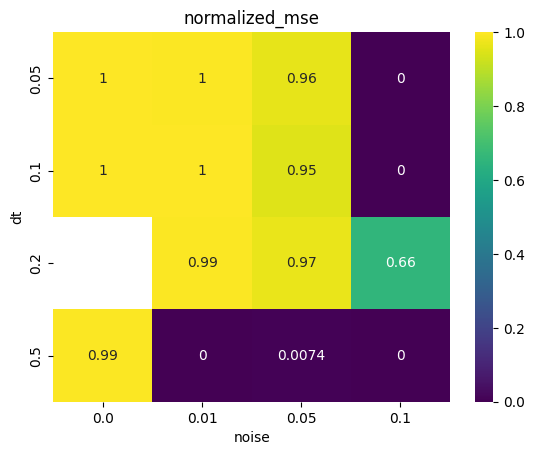

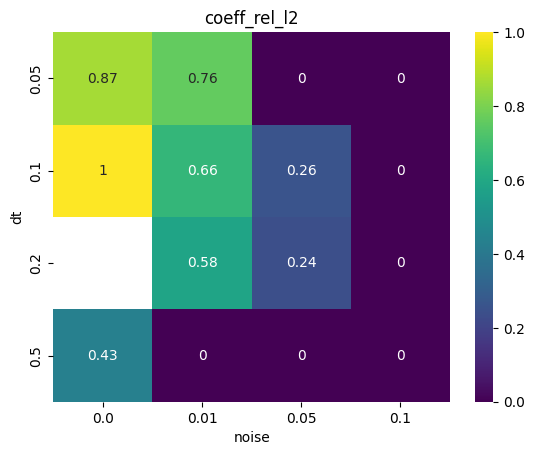

In [49]:
def heat_plot(df,metric,flip = True):
    pivot_df = df.pivot_table(index='dt', columns='noise', values=metric)
    if flip is True:
        pivot_df = 1-np.clip(pivot_df,0,1)
    sns.heatmap(pivot_df,annot=True, cmap="viridis",vmin = 0,vmax = 1)
    plt.title(metric)
    plt.show()
    
heat_plot(df,"relative_l2_error")
heat_plot(df,"normalized_mse")
heat_plot(df,"coeff_rel_l2")

In [50]:
df

,precision,recall,f1,coeff_rel_l2,coeff_rmse,coeff_mae,mse,rmse,mae,max_abs_error,normalized_mse,relative_l2_error,noise,dt
0,0.562500,1.000000,0.720000,1.128636,1.115119,0.411917,1.769020e-02,0.133005,6.806555e-02,0.789804,3.749009e-02,0.193535,0.05,0.05
1,0.750000,1.000000,0.857143,0.000027,0.000027,0.000009,3.687842e-12,0.000002,4.305410e-07,0.000040,7.815486e-12,0.000003,0.00,0.10
2,0.269231,0.777778,0.400000,2.149523,2.123780,1.058698,1.622957e-01,0.402859,2.651789e-01,2.774144,3.439463e-01,0.586202,0.10,0.20
3,0.500000,0.555556,0.526316,0.758615,0.749530,0.310283,1.595906e-02,0.126329,6.473718e-02,1.381223,3.382135e-02,0.183822,0.05,0.20
4,0.307692,0.888889,0.457143,927.373426,916.266757,369.258309,1.438285e+04,119.928502,3.790036e+01,752.539947,3.048095e+04,174.508225,0.10,0.10
5,0.900000,1.000000,0.947368,0.133216,0.131620,0.035986,1.053565e-04,0.010264,2.700085e-03,0.199497,2.232775e-04,0.014936,0.00,0.05
6,0.818182,1.000000,0.900000,0.337136,0.333099,0.112805,1.431835e-03,0.037840,1.836935e-02,0.426059,3.034427e-03,0.055060,0.01,0.10
7,0.250000,0.555556,0.344828,1339.708167,1323.663179,310.096378,3.079310e+05,554.915277,2.122348e+02,2529.659044,6.525850e+05,807.458432,0.10,0.50
8,0.500000,1.000000,0.666667,0.741261,0.732383,0.350489,2.317047e-02,0.152218,8.035749e-02,1.162874,4.910418e-02,0.221493,0.05,0.10
9,0.533333,0.888889,0.666667,0.569901,0.563075,0.236704,3.357716e-03,0.057946,1.873934e-02,1.026968,7.115865e-03,0.084317,0.00,0.50


## Investigate Failing case 
$dt = 0.2$ and noise $=0$

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from exp.expdata import LinearExp
from exp.evaluate.jsindy import evaluate_jmodel
import pickle
import jax.numpy as jnp

import time

def create_linear_experiment_data(noise, dt):
    initial_state = jnp.array([1., 0., 0., 1., -1., 0.])
    # sigma^2 - var
    true_sigma2 = noise
    t0=0
    t1=10.1
    n_train = len(jnp.arange(t0,t1,dt))

    n_colloc = 1000
    expdata = LinearExp(
        initial_state=initial_state,
        t0=t0,
        t1=t1,
        dt = 0.01,
        dt_train=dt,
        noise= jnp.sqrt(true_sigma2),
        seed=29,
        n_colloc=n_colloc,
        one_rkey=True,
        # feature_names=['x','y','z']
    )
    return expdata

def create_jsindy_model(feature_names = None):
    trajectory_model = CholDataAdaptedRKHSInterpolant()
    dynamics_model = FeatureLinearModel(
        reg_scaling = 1.,
        feature_map=PolyLib(degree=1)
    )
    optsettings = LMSettings(
        max_iter = 500,
        show_progress=True,
        no_tqdm=False,
        min_alpha = 1e-16,
        init_alpha = 5.,
        print_every=100
    )
    data_weight =  1.
    colloc_weight = 100.
    sparsifier = pySindySparsifier(STLSQ(threshold = 0.25,alpha = 1.))
    optimizer = AlternatingActiveSetLMSolver(
            beta_reg=0.001,
            solver_settings=optsettings,
            fixed_colloc_weight=colloc_weight,
            fixed_data_weight=data_weight,
            sparsifier = sparsifier
            )
    
    model = JSINDyModel(
        trajectory_model=trajectory_model,
        dynamics_model=dynamics_model,
        optimizer=optimizer,
        feature_names=feature_names
    )
    return model


def noise_dt_experiment(exp_folder: str = "jsindy_linear_results"):
    folder = Path(exp_folder)
    folder.mkdir(parents=True, exist_ok=True)

    noise_vars = jnp.array([0,0.01,0.05,0.1])[::-1]
    dt_vals = jnp.around(jnp.array([0.05, 0.1, 0.2,0.5]),4)[::-1]

    noise_vars = [jnp.array([0,0.01,0.05,0.1])[::-1][-1]]
    dt_vals = [jnp.around(jnp.array([0.05, 0.1, 0.2,0.5]),4)[::-1][1]]


    tot_exp = len(noise_vars)*len(dt_vals)

    idx=1
    for noise in noise_vars:
        for dt in dt_vals:
            print(f"Starting dt = {float(jnp.around(dt,3))}, noise = {float(jnp.around(noise,3))}")
            start_time = time.time()
            exp_name = f"noise_{float(jnp.around(noise,3))}_dt_{float(jnp.around(dt,3))}.dill"
            save_path = folder / exp_name

            try: 
                expdata = create_linear_experiment_data(noise,dt)
                jmodel = create_jsindy_model(expdata.feature_names)
                metrics = evaluate_jmodel(jmodel,expdata)
            except Exception as e:
                print(f"Error: {e}")
                continue

            with open(save_path, 'wb') as f:
                pickle.dump(metrics,f)

            l2_err = metrics["xdot_metrics"]["relative_l2_error"]

            tot_time = time.time() - start_time
            
            print(
                f"Finished exp {idx}/{tot_exp}, "
                f"noise: {float(jnp.around(noise,3))}, dt: {float(jnp.around(dt,3))}, "
                f"xdot err = {l2_err:.4e}, time = {tot_time:3.2f}."
            )
            idx += 1

if __name__ == "__main__":
    noise_dt_experiment(exp_folder="results")

Starting dt = 0.2, noise = 0.0


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 68.63, gradnorm = 3.726e+15, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 68.38, gradnorm = 5.773e+11, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 68.34, gradnorm = 2.646e+08, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 68.29, gradnorm = 2.079e+08, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 68.23, gradnorm = 2.991e+08, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 68.17, gradnorm = 4.305e+08, alpha = 1.674, improvement_ratio = 1.0
Iteration 100, loss = 1.945, gradnorm = 9.772e+10, alpha = 0.04368, improvement_ratio = 0.445
Iteration 200, loss = 8.486e-17, gradnorm = 6.777, alpha = 0.0001533, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 206, loss = 6.994e-18, gradnorm = 5.811, alpha = 1.434, improvement_ratio = -0.02709
Model after smooth warm start
(x0)' = 0.000
(x1)' = 0.000
(x2)' = 0.000
(x3)' = 0.000
(x4)' = 0.000
(x5)' = 0.000
Alternating Activeset Sparsifie

/home/grisal/github/jsindy/.venv/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.25) and eliminated all coefficients
  warnings.warn(


Error: sub got incompatible shapes for broadcasting: (12000,), (0,).
